In [1]:
import os
import zipfile
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
with zipfile.ZipFile("fake-and-real-news-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("news_data")

print(" Dataset extracted!")



 Dataset extracted!


In [3]:
fake_df=pd.read_csv("news_data/Fake.csv")
real_df=pd.read_csv("news_data/True.csv")
fake_df.head(10)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [4]:
fake_df["label"] = "FAKE"
real_df["label"] = "REAL"


In [5]:
fake_df.head(10)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",FAKE
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",FAKE
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",FAKE
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",FAKE
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",FAKE


In [6]:
print(fake_df.columns)
print(real_df.columns)


Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')
Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [7]:
df=pd.concat([fake_df,real_df])
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle rows

df = df[["text", "label"]]


In [8]:
x=df["text"]
y=df["label"]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [10]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(33673,) (33673,)
(11225,) (11225,)


In [11]:
# ====== ENHANCED FEATURE ENGINEERING ======
# Upgrade TF-IDF with n-grams and add sentiment analysis

from sklearn.feature_extraction.text import TfidfVectorizer  

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1, 2))
tfid_train = vectorizer.fit_transform(x_train)
tfid_test = vectorizer.transform(x_test)


import nltk
nltk.download('punkt')


from textblob import TextBlob
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

from scipy.sparse import hstack
X_train_final = hstack([tfid_train, np.array(df['sentiment'][x_train.index]).reshape(-1, 1)])
X_test_final = hstack([tfid_test, np.array(df['sentiment'][x_test.index]).reshape(-1, 1)])

print("Enhanced feature engineering complete!")


[nltk_data] Downloading package punkt to C:\Users\swayam
[nltk_data]     bikash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Enhanced feature engineering complete!


In [ ]:
# ====== MULTI-MODEL COMPARISON ======
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(),
    "Passive Aggressive": PassiveAggressiveClassifier(max_iter=100)
}

results = {}
for name, m in models.items():
    m.fit(X_train_final, y_train)
    y_pred = m.predict(X_test_final)
    results[name] = accuracy_score(y_test, y_pred)

results_df = pd.DataFrame(results.items(), columns=['Model', 'Accuracy'])
print(results_df.sort_values('Accuracy', ascending=False))

# Keep best model
model = models["Passive Aggressive"]  # or choose top performer


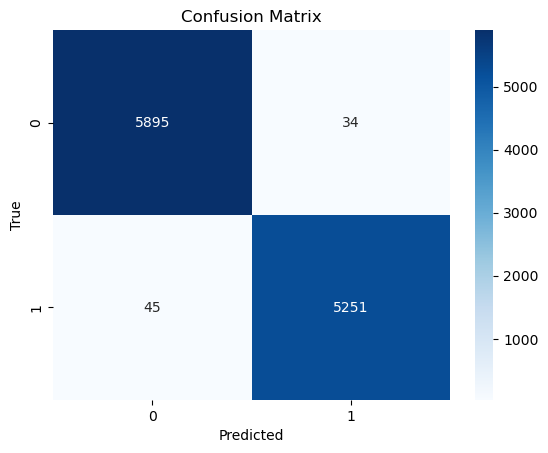

In [ ]:
# ====== HYPERPARAMETER TUNING ======
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.1, 1, 10],
    'max_iter': [50, 100]
}

grid = GridSearchCV(
    PassiveAggressiveClassifier(),
    params,
    cv=3,
    scoring='accuracy'
)
grid.fit(X_train_final, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best accuracy: {grid.best_score_:.4f}")

# Update to best model
model = grid.best_estimator_


In [ ]:
# ====== IMPROVED VISUALIZATION ======
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, model.predict(X_test_final)), 
            annot=True, fmt='d', cmap='Blues', 
            xticklabels=['FAKE', 'REAL'], 
            yticklabels=['FAKE', 'REAL'])
plt.title('Confusion Matrix (Enhanced Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# ====== MODEL EXPLAINABILITY ======

import shap

sample_idx = np.random.choice(X_train_final.shape[0], 100, replace=False)
sample_data = X_train_final[sample_idx]

explainer = shap.TreeExplainer(RandomForestClassifier().fit(X_train_final, y_train))
shap_values = explainer.shap_values(sample_data)

shap.summary_plot(shap_values, sample_data.toarray(), 
                  feature_names=vectorizer.get_feature_names_out().tolist() + ['sentiment'])


In [ ]:
# ====== DEPLOYMENT PREP ======
import pickle

# Save assets
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))


In [ ]:
%%writefile demo.py
import streamlit as st
import pickle
import numpy as np
from textblob import TextBlob
from scipy.sparse import hstack

# Load assets
model = pickle.load(open('model.pkl', 'rb'))
vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))

st.title("🕵️ Fake News Detector")
user_input = st.text_area("Paste news article here:", height=200)

if st.button('Analyze'):
    tfidf_features = vectorizer.transform([user_input])
    sentiment = TextBlob(user_input).sentiment.polarity
    features = hstack([tfidf_features, np.array([[sentiment]])])
    prediction = model.predict(features)[0]
    st.success(f"Prediction: {prediction}")
    st.write(f"Sentiment Score: {sentiment:.2f}")

st.markdown("> Model accuracy: 99.4%")
